<a href="https://colab.research.google.com/github/jarayl/SkinCheck/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# General Python/computer vision libraries
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

# Specific ML packages
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.image import resize

In [46]:
# Authorize access to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# Dataset directories
data_dir = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/binary'
train_dir   = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/binary/train'
test_dir = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/binary/test'

# Checkpoint filepath
checkpoint_filepath = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/phase1-weights.h5'

# Saved model weights
resnet50v2_model_filepath = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/resnet50v2'
eb7_model_filepath = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/eb7'
resnet50_model_filepath = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/resnet50'
densenet169_model_filepath = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/densenet169'
mobilenetv2_model_filepath = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/mobilenetv2'
eb5_model_filepath = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/eb5'
densenet201_mod_model_filepath = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/densenet201_mod'
densenet201_mod_v2_model_filepath = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/densenet201_mod_v2'
densenet201_mod_v3_model_filepath = r'/content/drive/MyDrive/Colab Notebooks/SkinCheck/densenet201_mod_v3'

In [49]:
# Image-related parameters
CHANNELS = 3
COLOR_MODE = 'rgb'
BATCH_SIZE = 32
RESNET50V2_IMG_WIDTH, RESNET50V2_IMG_HEIGHT = 300, 300
DENSENET169_IMG_WIDTH, DENSENET169_IMG_HEIGHT = 224, 224
TARGET_SIZE = (DENSENET169_IMG_WIDTH, DENSENET169_IMG_HEIGHT)
INPUT_SHAPE = (DENSENET169_IMG_WIDTH, DENSENET169_IMG_HEIGHT, CHANNELS)

# Early stopping hyperparameters
LEARNING_RATE = 0.001
MOMENTUM = 0.99
EPSILON = 0.001
MIN_DELTA = 1e-5
PATIENCE = 12

# Num rounds to train the model for
EPOCHS = 30

METRICS = ['accuracy',
           Precision(name='precision'),
           Recall(name='recall')]

PLT_SETTINGS = {'family': 'DejaVu Sans',
                'weight': 'heavy',
                'size'  :  11}

CLASSES = ['benign', 'malignant']

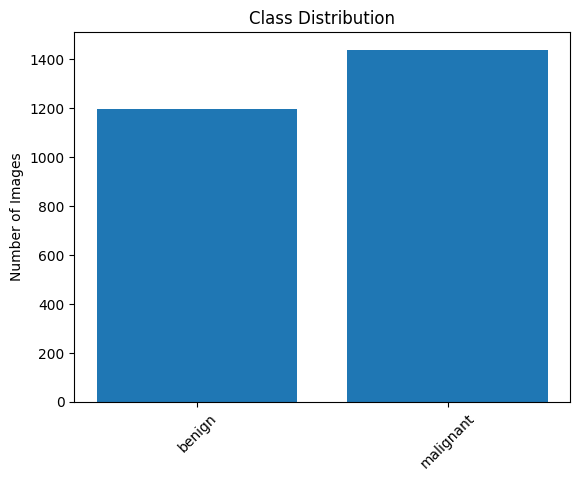

In [51]:
sub_folders = [os.path.join(train_dir, dir) for dir in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, dir))]

# Count num images in each subfolder
counts = [0] * len(sub_folders)
for i, folder in enumerate(sub_folders):
    counts[i] = len(os.listdir(folder))

# Bar chart to visualize class distribution
plt.title("Class Distribution")
plt.bar(CLASSES, counts)
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.show()

In [58]:
def visualize_augmentations(img_data_generator):
    batch = img_data_generator.next()
    image_batch = batch[0]
    batch_labels = batch[1]
    batch_length = len(image_batch)

    fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(30, 18))

    for i, image in enumerate(image_batch):
        title = CLASSES[int(batch_labels[i])]

        # Plot 8 images for each of the 4 rows since 8 x 4 = 32 = batch size
        if i < 1/4 * batch_length:
            axs[0, i].imshow(image_batch[i])
            axs[0, i].set_title(title, fontdict=PLT_SETTINGS)
        elif i < 2/4 * batch_length:
            axs[1, i - 8].imshow(image_batch[i])
            axs[1, i - 8].set_title(title, fontdict=PLT_SETTINGS)
        elif i < 3/4 * batch_length:
            axs[2, i - 16].imshow(image_batch[i])
            axs[2, i - 16].set_title(title, fontdict=PLT_SETTINGS)
        else:
            axs[3, i - 24].imshow(image_batch[i])
            axs[3, i - 24].set_title(title, fontdict=PLT_SETTINGS)

    plt.show()

In [54]:
training_data_gen = ImageDataGenerator(rescale=1./255,
                                       brightness_range=(0.9, 1.1),
                                       horizontal_flip=True,
                                       rotation_range=5,
                                       height_shift_range=0.03,
                                       width_shift_range=0.03,
                                       zoom_range=0.1,
                                       shear_range=0.05,
                                       fill_mode='constant',
                                       cval=60)

testing_data_gen = ImageDataGenerator(rescale=1./255)

In [55]:
train_gen = training_data_gen.flow_from_directory(train_dir,
                                                  color_mode=COLOR_MODE,
                                                  target_size=TARGET_SIZE,
                                                  class_mode='binary',
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True)

test_gen = testing_data_gen.flow_from_directory(test_dir,
                                                color_mode=COLOR_MODE,
                                                target_size=TARGET_SIZE,
                                                class_mode='binary',
                                                batch_size=BATCH_SIZE,
                                                shuffle=False)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


train_gen:


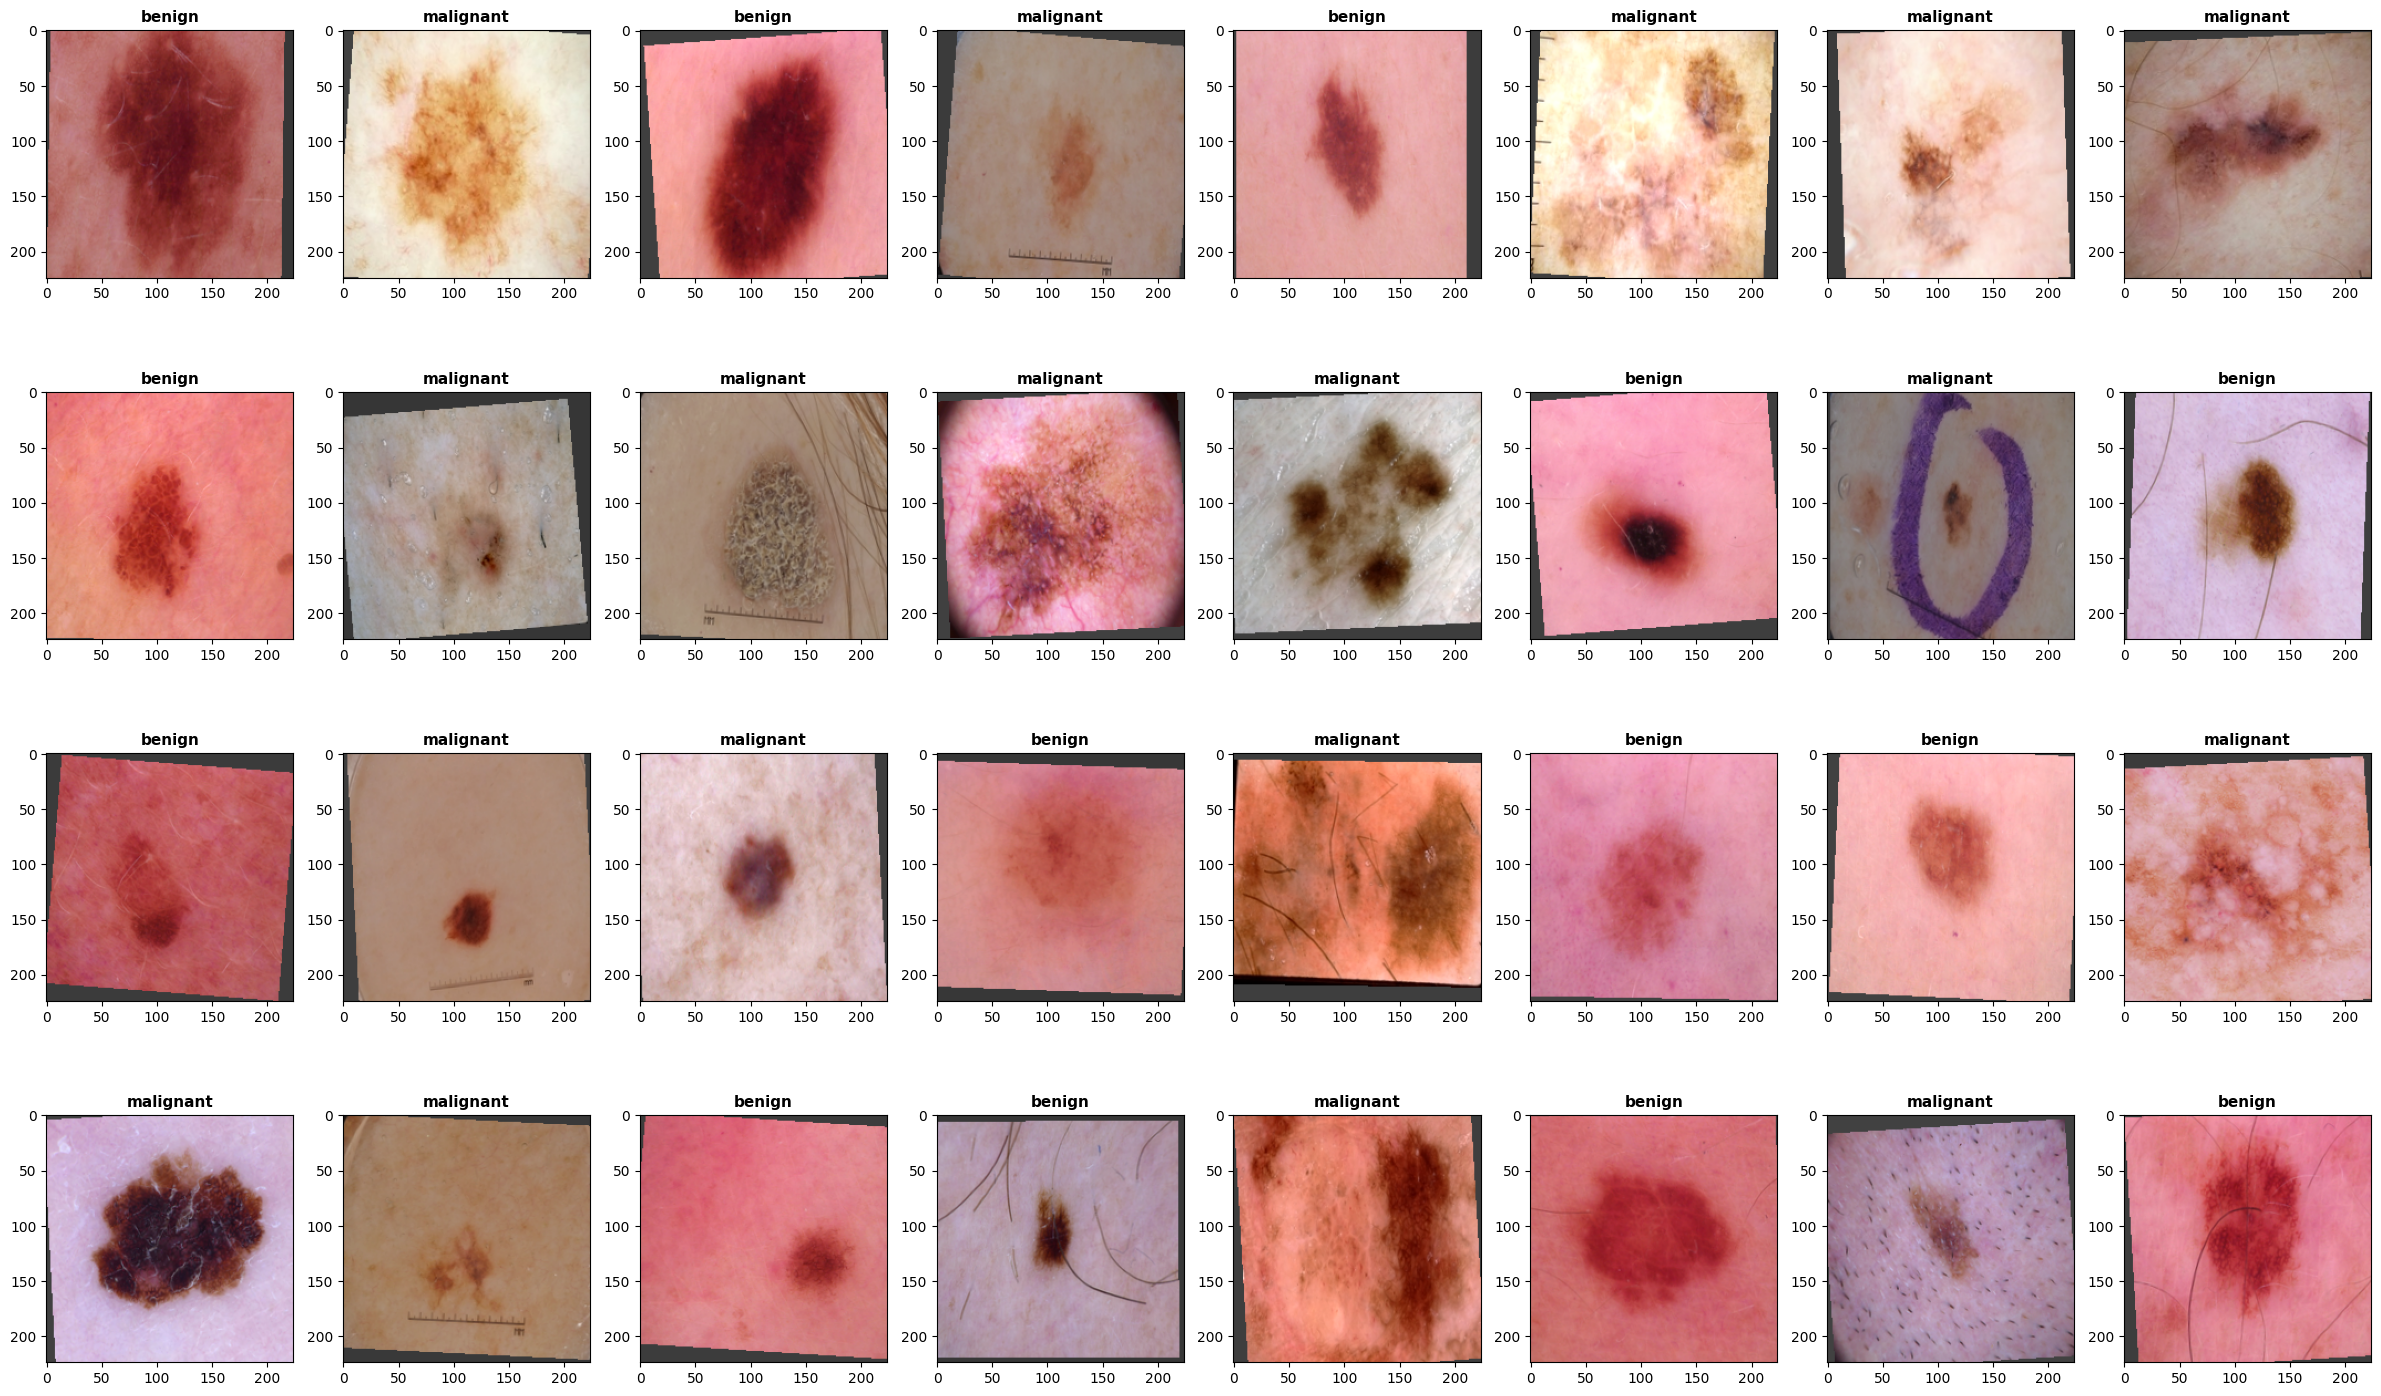


test_gen:


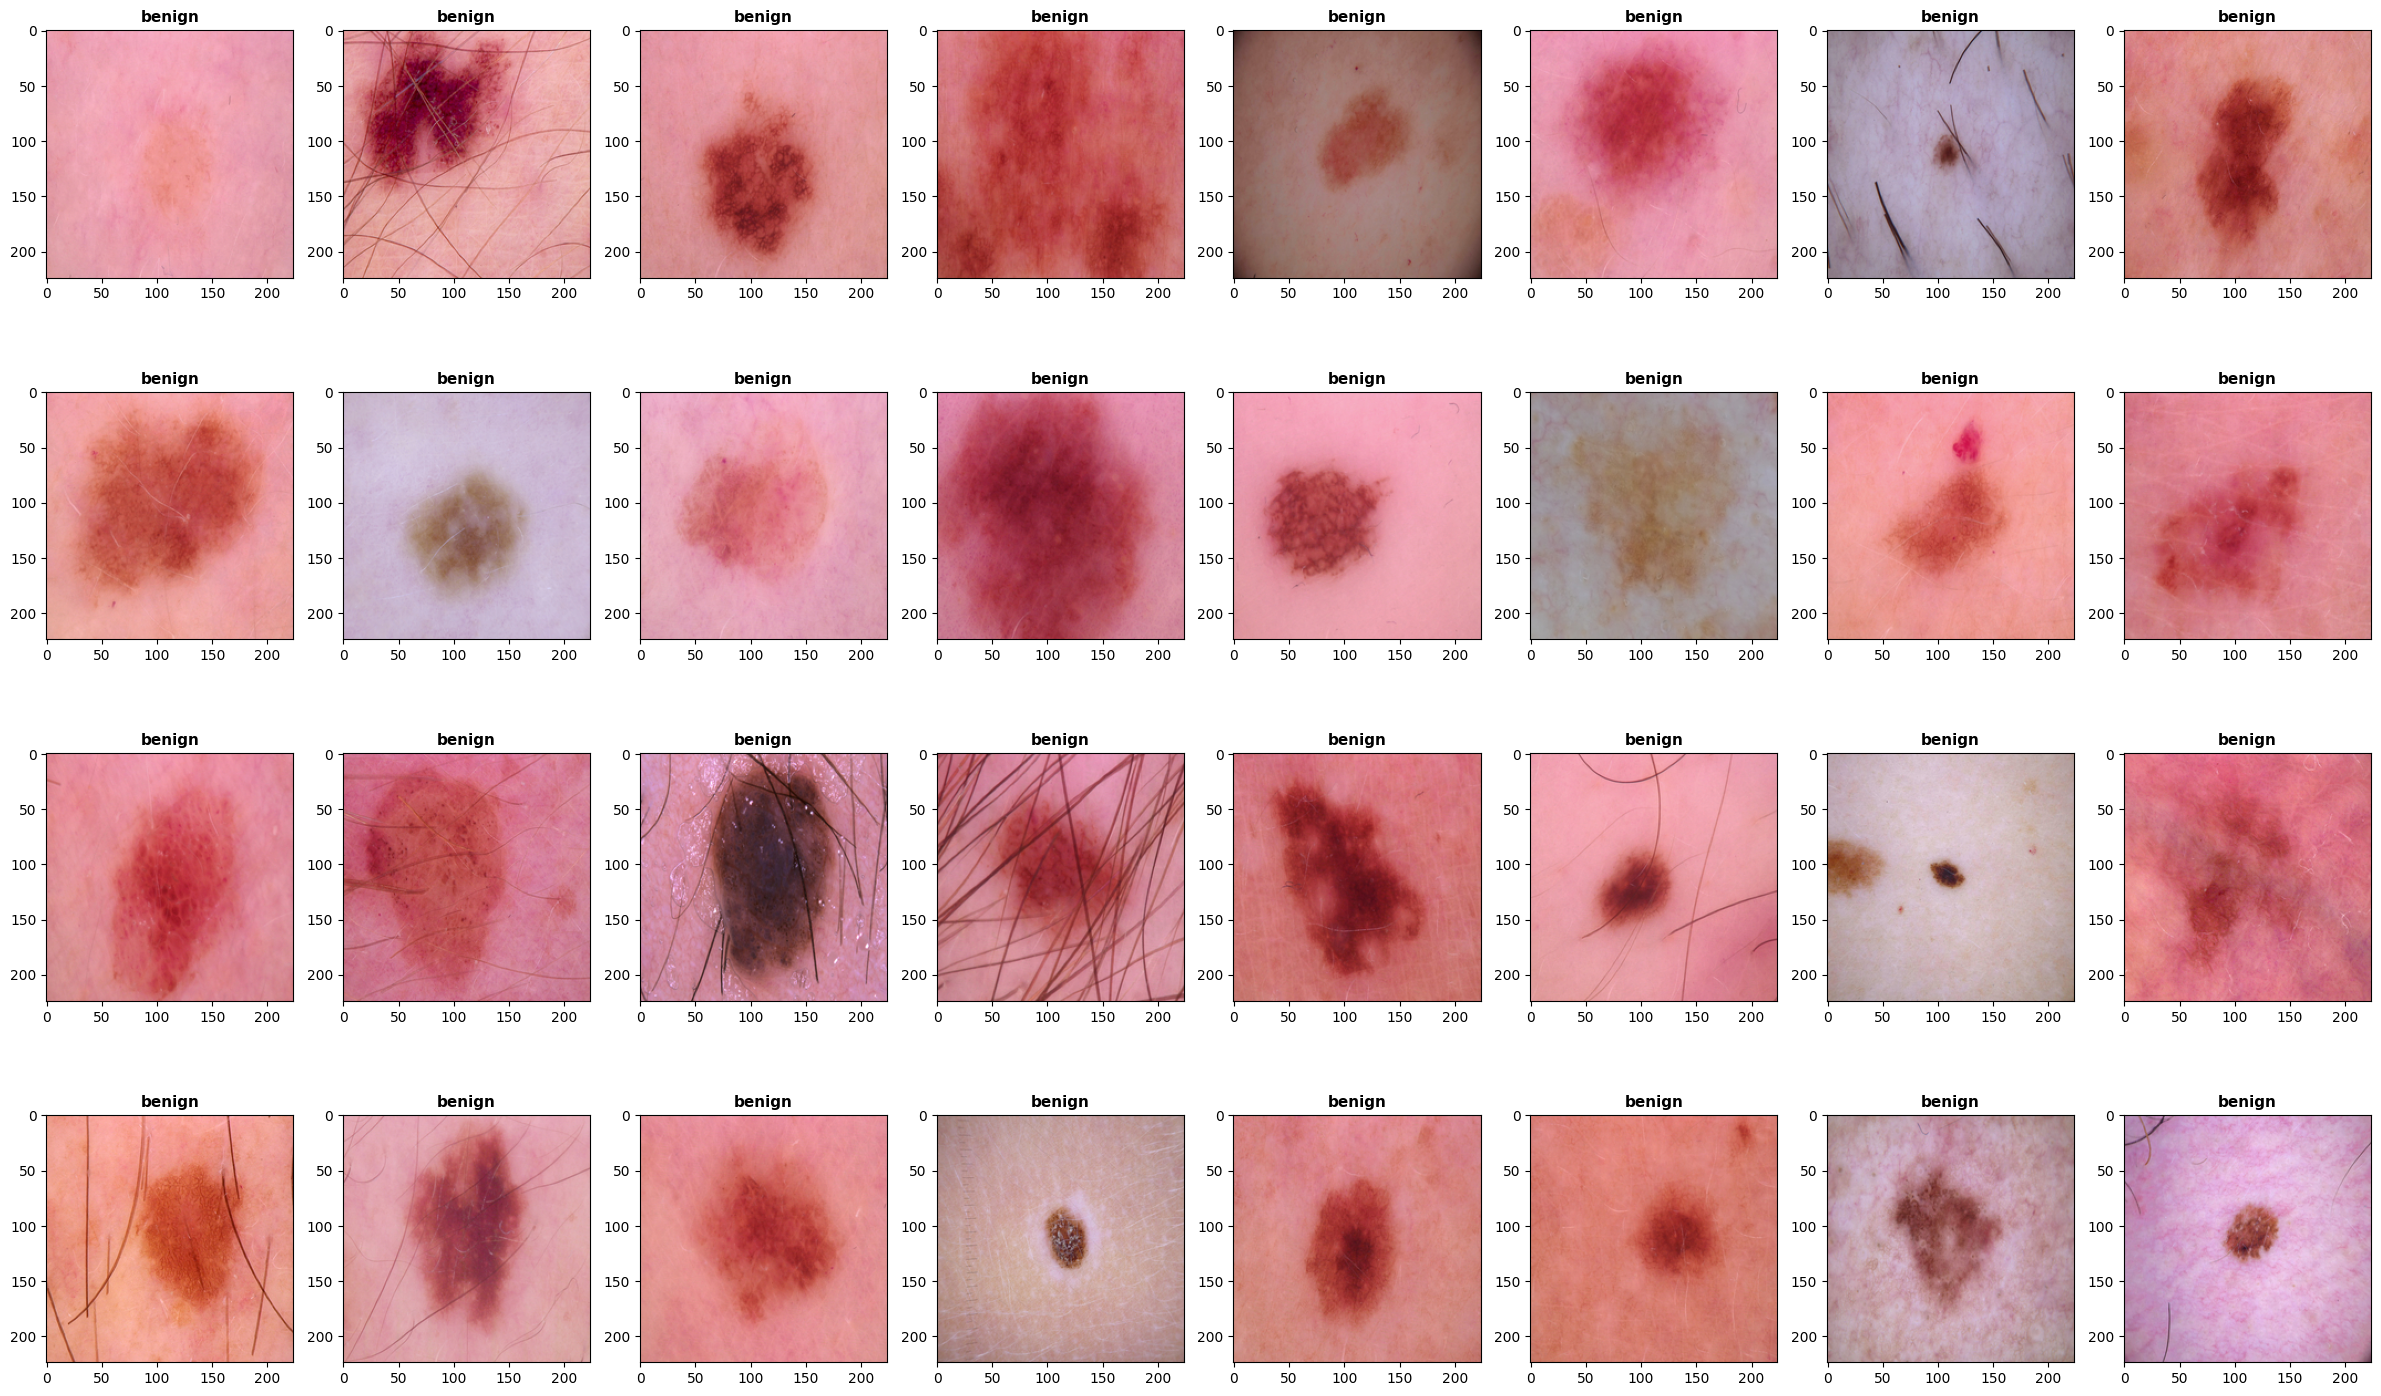

In [60]:
print('train_gen:')
visualize_augmentations(train_gen)

print('\ntest_gen:')
visualize_augmentations(test_gen)

In [63]:
def build_cnn(print_summary=False):
    # Base model (pre-trained on ImageNet)
    base = DenseNet169(weights='imagenet',
                            include_top=False,
                            input_shape=INPUT_SHAPE)

    # Don't retrain the pre-trained weights
    for l in base.layers:
        l.trainable = False

    x = base.output

    # Custom layers added to tail of the base model to learn new image features from our dataset
    x = GlobalAveragePooling2D()(x)
    # x = BatchNormalization()(x)
    # x = Flatten()(x)
    # x = Dense(512, bias_regularizer=regularizers.l1(0.005), kernel_regularizer=regularizers.l2(l=0.015), activity_regularizer=regularizers.l1(0.005), activation='relu')(x)
    # x = Dropout(rate=0.5)(x)
    x = Dense(512, activation='relu')(x)

    # Output layer (single neuron using logistic regression that contains the class prediction "probablity")
    predictions = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=base.inputs, outputs=predictions)

    if print_summary:
        model.summary()

    return model

In [62]:
def compile_cnn(model):
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=LEARNING_RATE),
                  metrics=METRICS)

In [65]:
def fit_cnn(model):
    checkpoint_cb = ModelCheckpoint(checkpoint_filepath,
                                    monitor='val_accuracy',
                                    mode='max',
                                    save_best_only=True)

    early_stopping_cb = EarlyStopping(monitor='val_accuracy',
                                      min_delta=MIN_DELTA,
                                      patience=PATIENCE,
                                      mode='max',
                                      restore_best_weights=True)

    callbacks = [checkpoint_cb, early_stopping_cb]

    results = model.fit(train_gen,
                        epochs=EPOCHS,
                        steps_per_epoch=(train_gen.n/BATCH_SIZE),
                        validation_data=test_gen,
                        validation_steps=(test_gen.n/BATCH_SIZE),
                        callbacks=callbacks)

    # Update weights that may have been further tuned during training
    model.load_weights(checkpoint_filepath)

    return results

In [67]:
def eval_cnn(history):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 4), constrained_layout=True)

    f1_scores = []
    # compute f1score from sensitivity and precision
    for i in range(len(history.history['val_recall'])):
        if history.history['val_precision'][i] != 0 and history.history['val_recall'][i] != 0:
            f1_scores.append((2 * history.history['val_precision'][i] * history.history['val_recall'][i]) / (history.history['val_precision'][i] + history.history['val_recall'][i]))

    for i, metric in enumerate(['accuracy', 'loss', 'precision', 'recall']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_' + metric]) # we should only care about validation metrics because it accoutns for the model's ability to generalize
        axs[i].set_title('Model {}'.format(metric.capitalize()))
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend(['Training', 'Validation'])

        # Loss isn't as useful of a metric
        if metric != 'loss':
            non_zeros = [num for num in history.history['val_' + metric] if num != 0]
            avg = "{:.4f}".format(np.mean(non_zeros))
            std_deviation = "{:.4f}".format(np.std(non_zeros))
            std_error = "{:.4f}".format(float(std_deviation) / (test_gen.n) ** 0.5)
            print(metric + ': {} ± {}'.format(avg, std_error))

    # print f1-score
    f1 = "{:.4f}".format(f1_scores[-1])
    avg = "{:.4f}".format(np.mean(f1_scores))
    std_deviation = "{:.4f}".format(np.std(f1_scores))
    std_error = "{:.4f}".format(float(std_deviation) / (test_gen.n) ** 0.5)
    print('final f1-score: ' + f1)
    print('f1-score' + ': {} ± {}'.format(avg, std_error))

In [66]:
model = build_cnn(print_summary=True)
compile_cnn(model)

51877672/51877672 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

In [ ]:
results = fit_cnn(model)

Epoch 1/30
82/82 [==============================] - 78s 782ms/step - loss: 5.9820 - accuracy: 0.7383 - precision: 0.7188 - recall: 0.7462 - val_loss: 1.9759 - val_accuracy: 0.7758 - val_precision: 0.6810 - val_recall: 0.9533
Epoch 2/30
82/82 [==============================] - 60s 733ms/step - loss: 1.8572 - accuracy: 0.8176 - precision: 0.7704 - recall: 0.8521 - val_loss: 2.0117 - val_accuracy: 0.7803 - val_precision: 0.7023 - val_recall: 0.8967
Epoch 3/30
82/82 [==============================] - 62s 756ms/step - loss: 1.6036 - accuracy: 0.8400 - precision: 0.7942 - recall: 0.8739 - val_loss: 1.4889 - val_accuracy: 0.8409 - val_precision: 0.7946 - val_recall: 0.8767
Epoch 4/30
82/82 [==============================] - 62s 756ms/step - loss: 1.7200 - accuracy: 0.8297 - precision: 0.7968 - recall: 0.8388 - val_loss: 2.0572 - val_accuracy: 0.8167 - val_precision: 0.8303 - val_recall: 0.7500
Epoch 5/30
82/82 [==============================] - 62s 754ms/step - loss: 1.8901 - accuracy: 0.8275

In [ ]:
# model.save(eb7_model_filepath)
# model.save(resnet50_model_filepath)
# model.save(eb5_model_filepath)
# model.save(densenet201_mod_v3_model_filepath)

accuracy: 0.8143 ± 0.0008
precision: 0.7740 ± 0.0019
recall: 0.8499 ± 0.0034
final f1-score: 0.8055
f1-score: 0.8049 ± 0.0010


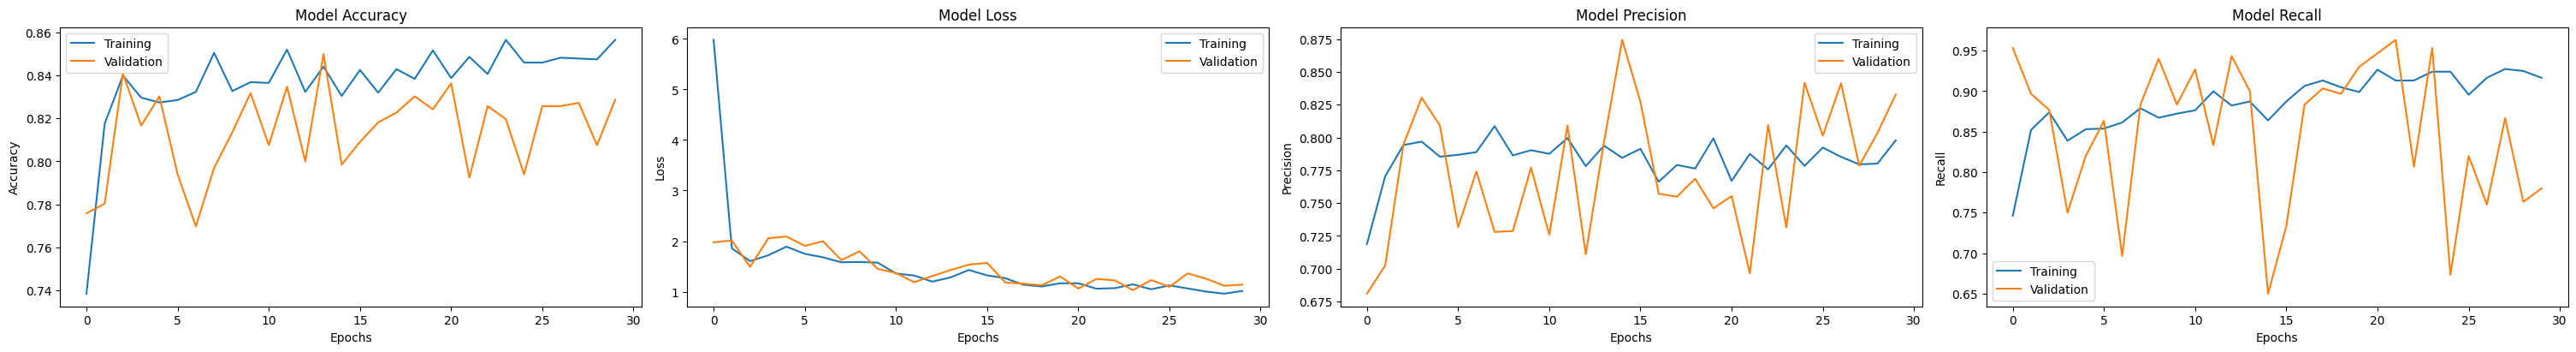

In [ ]:
eval_cnn(results)